In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import os
import time
import datetime as dt
from sklearn import linear_model
import sklearn as skl
from sklearn import datasets
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing as prep
from packages import tools
import importlib
from functools import reduce
import warnings
from pprint import pprint

In [2]:
warnings.filterwarnings('ignore')
os.getcwd()

'C:\\Users\\nvolf\\Google Drive 2\\5th Year (Masters) Modules\\Third Semester'

In [ ]:
default_backend = 'module://ipykernel.pylab.backend_inline'

# X-Model

In this notebook, we attempt to replicate the general method in the following article: <a href="https://arxiv.org/pdf/1509.00372.pdf">Electricity Price Forecasting using Sale and Purchase Curves: The X-Model</a>.

### The Method:
The basic idea is to view the bid and supply volumes as processes in time. We model these processes and forecast the price by finding the 'intersection' of these two curves at any given time. The general steps are as follows:
   1. <b>Create price classes</b> (dimension reduction) to make the modelling and forecasting process computationally feasible.
   2. <b>Design and train the (time series) model to forecast bid volume processes</b>
   3. <b>Forecast future bid volumes, reconstruct original price curves, then determine corresponding prices</b>

### Some things to note:
1. The article implements the method on EPEXSPOT DAM data for Germany and Austria. We are (initially) implementing the method on EPEXSPOT DAM data for Ireland (excluding Northern Ireland).
2. The ultimate goal here is to provide forecasts for the electricity price based on the model. As we progress through the notebook, some sections were written for illustration purposes or for explaining something about the data.
3. Some of the functions were designed with more parameters/functionalities than is necessary for the task at hand, but in expectation of potentially expanding the method, we try to make the functions as flexible and adaptable as we can.
4. When referring to the demand and supply curves, we use interchangeable terms, i.e. 'price' curves, 'supply'/'sell'/'sale' curve, 'demand'/'purchase' curve.

### Load data

In [3]:
path_ba1 = "Datasets/BidAskCurvve1.csv"
path_ba2 = "Datasets/BidAskCurvve2.csv"
path_ba3 = "Datasets/BidAskCurvve3.csv"

In [4]:
ba1 = pd.read_csv(path_ba1)
ba2 = pd.read_csv(path_ba2)
ba3 = pd.read_csv(path_ba3)

### Combine data

In [5]:
ba = ba1.append(ba2.append(ba3, ignore_index=True), ignore_index=True)

In [6]:
ba.dtypes

DeliveryDay       object
TimeStepID        object
PurchaseVolume    object
PurchasePrice     object
SellVolume        object
SellPrice         object
dtype: object

In [ ]:
ba.head()

### Verify data integrity and clean data (ensure consistent data types, remove duplicate days/hours, sort by delivery date/time)

Note: Daylight Savings Time adjustments are applied in the modelling step (2).

In [7]:
def clean_TimeStepID(TimeStepID):
    # If no need to edit, return the same value
    if type(TimeStepID) == int:
        return(TimeStepID)
    
    # Remove letter/s
    if re.search(".*B$", TimeStepID):
        pos = re.search("B", TimeStepID).start()
    else:
        return(int(TimeStepID))
    
    # Remove letter and convert to int
    return(int(TimeStepID[:pos]))


def clean_data(dataframe):
    # Remove duplicates
    dataframe = dataframe.drop_duplicates()
    
    # Ensure data types are consistent, i.e. DeliveryDay is date, TimeStepID is int, etc.
    dataframe.loc[:,"DeliveryDay"] = pd.to_datetime(dataframe["DeliveryDay"], format="%Y-%m-%d")   
    dataframe.loc[:,"TimeStepID"] = dataframe["TimeStepID"].apply(clean_TimeStepID)
    dataframe = dataframe.sort_values(by=["DeliveryDay","TimeStepID"]).reset_index(drop=True)
    
    # Convert TimeStepID to zero-index, i.e. {0,...,23}
    dataframe["TimeStepID"] = dataframe["TimeStepID"] - 1
    
    # Combine DeliveryDay and TimeStepID into one date column, "DeliveryPeriod", and set as index
    dataframe["DeliveryPeriod"] = [day + dt.timedelta(hours=hour) for (day, hour) in zip(dataframe["DeliveryDay"], dataframe["TimeStepID"])]
    dataframe.set_index("DeliveryPeriod", inplace=True)
    
    # Remove redundant columns
    dataframe.drop(["DeliveryDay", "TimeStepID"], axis=1, inplace=True)
    
    return(dataframe)

In [8]:
ba = clean_data(ba)

In [ ]:
ba.head()

In [ ]:
ba.dtypes

### Get Price Curve

We define function to fetch price curve for a given index in the bid ask dataframe

In [9]:
def get_price_curves(dataframe, index, return_vals="both", aggregated=False, plot=False, xlim=None, ylim=None):
    # Extract bid volumes and corresponding bid prices for that delivery hour
    pv = list(map(float,dataframe.loc[:,"PurchaseVolume"][index].split(",")))
    sv = list(map(float,dataframe.loc[:,"SellVolume"][index].split(",")))
    pp = list(map(float, dataframe.loc[:,"PurchasePrice"][index].split(",")))
    sp = list(map(float,dataframe.loc[:,"SellPrice"][index].split(",")))
    
    # Combine bid data and supply data into their own dataframes, and add a column of aggregated volume to each df.
    if return_vals == "purchase":
        purchase = pd.DataFrame(dict(PurchaseVolume=pv, PurchasePrice=pp)).sort_values(by="PurchasePrice", ascending=False)
        if aggregated:
            purchase["AggregatedPurchaseVolume"] = purchase[["PurchaseVolume"]].cumsum()
        
    elif return_vals == "sell":
        sell = pd.DataFrame(dict(SellVolume=sv, SellPrice=sp)).sort_values(by="SellPrice")
        if aggregated:
            sell["AggregatedSellVolume"] = sell[["SellVolume"]].cumsum()
        
    elif return_vals == "both":
        purchase = pd.DataFrame(dict(PurchaseVolume=pv, PurchasePrice=pp)).sort_values(by="PurchasePrice", ascending=False)
        sell = pd.DataFrame(dict(SellVolume=sv, SellPrice=sp)).sort_values(by="SellPrice")
        
        if aggregated:
            purchase["AggregatedPurchaseVolume"] = purchase[["PurchaseVolume"]].cumsum()
            sell["AggregatedSellVolume"] = sell[["SellVolume"]].cumsum()
    
    # For illustration (and confirmation of expectations)
    if plot and aggregated:
        xlim = (purchase["AggregatedPurchaseVolume"].min(),
                purchase["AggregatedPurchaseVolume"].max()) if xlim==None else xlim
        ylim = (-100, 300) if ylim==None else ylim
        ax = purchase.drop(["PurchaseVolume"], axis=1).plot(x="AggregatedPurchaseVolume")
        sell.drop(["SellVolume"], axis=1).plot(x="AggregatedSellVolume", ax=ax)
        ax.set_xlabel("Volume")
        ax.set_ylabel("Price")
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    
    if plot and not aggregated:
        print("Warning: cannot plot if aggregated=False")
           
    # Return the purchase/sell curve data
    if return_vals == "purchase":
        return(purchase) 
    elif return_vals == "sell":
        return(sell)
    elif return_vals == "both":
        return(purchase, sell)

Mathematical formula for supply and demand curves:

\begin{equation}
        S_t(P) = \mathop{\sum\limits_{p \in \mathbb{P}_{S,t}}}_{p \leq P} V_{S,t}(p) \text{ for } P \in \mathbb{P}_{S,t} \text{ and }
        D_t(P) = \mathop{\sum\limits_{p \in \mathbb{P}_{D,t}}}_{p \geq P} V_{D,t}(p) \text{ for } P \in \mathbb{P}_{D,t} 
\end{equation}

Sample supply and demand curve for a given hour:

In [ ]:
bid_curve, ask_curve = get_price_curves(ba, 1, plot=True, aggregated=True)

In [ ]:
ask_curve.head()

### 1. Construct Price Classes

EPEX SPOT prices range between -500 and 3000, in increments of 0.1, e.g. $\mathbb{P} = \{-500.0,-499.9,-499.8\ldots,2999.7, 2999.8,2999.9,3000.0\}$, so there are 35,001 possible prices. If computational expense was not an issue, then we would model the bid volume of each price point in time, giving us two price processes (demand and supply) each consisting of 35,001 components. Of course, the majority of these prices will almost always be 0. Because of this, and for computational feasibility, we implement a simple dimension reduction technique of grouping the bid volumes by price class.

The method outline is as follows:
   1. <b>Calculate mean bid volumes per price across the whole time range spanned by our dataset.</b> Note: we exclude prices that were always 0, e.g. if no bid was ever made for the price -461.5, then we don't include this in the dataframe, as it will be implicitly processed as a 0 anyway.
   2. <b>Construct a supply and demand curve from the mean bid volumes</b> as we did above.
   3. <b>Use equidistant volume classes to determine the lengths of the price classes</b>. We will give a visual representation of this later.

So firstly, we calculate the mean bid volumes. We will use the above function `get_price_curves()` to help us.

In [10]:
# This takes a while to run as it will loop through thousands of rows
def get_mean_volumes(dataframe, start_index=0, end_index=-1, price_curve="both"):
    n = dataframe.shape[0]
    end_index = n if end_index == -1 else end_index
    
    # Create dataframes for combining hourly purchase and sell bids
    combined_purchase = pd.DataFrame(columns=["PurchaseVolume", "PurchasePrice"])
    combined_sell = pd.DataFrame(columns=["SellVolume", "SellPrice"])
    
    # Combine the bids
    for i in range(start_index, end_index):
        hourly_purchase, hourly_sell = get_price_curves(ba, i)
        combined_purchase = combined_purchase.append(hourly_purchase, ignore_index=True)
        combined_sell = combined_sell.append(hourly_sell, ignore_index=True)
    
    # Calculate the mean volumes across each distinct price. Note: we divide by n rather than using .mean() function
    # since there are many times when a volume for a given price is 0. The .mean() function does not take this into account,
    # and we want to include the 0 values in the calculation of the mean.
    mean_purchase = combined_purchase.groupby(["PurchasePrice"]).sum()/n
    mean_sell = combined_sell.groupby(["SellPrice"]).sum()/n
    
    return(mean_purchase, mean_sell)

Values were stored beforehand to make running easier. The commented code takes a few minutes to run. Make sure to run that first and store it in your computer using the next cell.

In [11]:
mean_purchase = pd.read_csv("Variables/mean_purchase.csv", index_col="PurchasePrice")
mean_sell = pd.read_csv("Variables/mean_sell.csv", index_col="SellPrice")

# start_time = time.time()
# mean_purchase, mean_sell = get_mean_volumes(ba)
# print(f"Execution time: {time.time() - start_time} seconds")

Store the mean bid volumes in local directory to save time in future runs.

In [12]:
if not os.path.exists("Variables"):
    os.mkdir("Variables")

mean_purchase.to_csv("Variables/mean_purchase.csv")
mean_sell.to_csv("Variables/mean_sell.csv")

Here, we create the 'aggregated' volumes for the (average) supply and demand data, giving us the mean supply and demand curves.

In [13]:
def to_price_curve(bid_dataframe, curve_type):
    # Sort dataframe by prices (increasing order for supply curve, decreasing order for demand curve)
    if curve_type == "sell":
        sorted_bid_dataframe = bid_dataframe.sort_values(by=["SellPrice"], ascending=True)
    elif curve_type == "purchase":
        sorted_bid_dataframe = bid_dataframe.sort_values(by=["PurchasePrice"], ascending=False)

    # Calculate cumulative volumes
    column_name = "PurchaseVolume" if curve_type == "purchase" else "SellVolume"
    agg_column_name = "AggregatedPurchaseVolume" if curve_type == "purchase" else "AggregatedSellVolume"
    
    sorted_bid_dataframe[agg_column_name] = sorted_bid_dataframe[column_name].cumsum()
    
    return(sorted_bid_dataframe)

In [14]:
mean_purchase_curve = to_price_curve(mean_purchase, curve_type="purchase")
mean_sell_curve = to_price_curve(mean_sell, curve_type="sell")

This function is just for illustration (and to confirm visually that we did it correctly)

In [15]:
def plot_price_curves(purchase, sell, xlim=None, ylim=None, classes=None, linewidth=0.8):
    xlim = (0, max(purchase[["AggregatedPurchaseVolume"]].max()[0],
                  sell[["AggregatedSellVolume"]].max()[0])) if xlim == None else xlim
    ylim = (-500,3000) if ylim == None else ylim
    
    ax = purchase.drop(["PurchaseVolume"], axis=1).reset_index().plot(y=["PurchasePrice"], x="AggregatedPurchaseVolume")
    sell.drop(["SellVolume"], axis=1).reset_index().plot(y=["SellPrice"], x="AggregatedSellVolume", ax=ax, xlim=xlim, ylim=ylim)
    ax.set_ylabel("Price"); ax.set_xlabel("Mean Volume")
    
    if classes is not None:
        purchase_classes, sell_classes = classes
        
        for points in purchase_classes.values:
            volume = points[0]
            price = points[1]
            
            ax.hlines(price, xmin=0, xmax=volume, color="blue", linestyle="--", linewidth=linewidth)
            ax.vlines(volume, ymin=-500, ymax=price, color="blue", linestyle="--", linewidth=linewidth)
            
        for points in sell_classes.values:
            volume = points[0]
            price = points[1]
            
            ax.hlines(price, xmin=0, xmax=volume, color="orange", linestyle="--", linewidth=linewidth)
            ax.vlines(volume, ymin=-500, ymax=price, color="orange", linestyle="--", linewidth=linewidth)    
    
    plt.show()

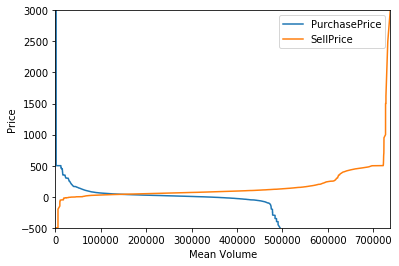

In [16]:
plot_price_curves(mean_purchase_curve, mean_sell_curve)#, ylim=(-60,180))

It kind of looks right...

Now that we have the mean supply and demand curves for the period, we can finally create our price classes.

<b>Main idea:</b> Because the price curves are monotonic, we can use the inverse function of the price curves to get a distinct price for every given volume amount.

Note: It is theoretically possible to get the same price class more than once, e.g. for a completely horizontal curve. However, our choice of volume class length is large enough that this will not happen in practice.

In [17]:
""" Each purchase (demand) curve price class is determined by its lower bound, and
    each sell (supply) curve price class is determined by its upper bound.
    
    The class_length parameter can be chosen arbitrarily or with some justification. Our choice of 31000 is to so
    that we have a similar number of classes as in the paper (which had 16 purchase/sell classes).
"""
def create_price_classes(mean_purchase_curve, mean_sell_curve, class_length=35000, decimals=2):
    # Initialise and prepare price class dataframes.
    purchase_df = mean_purchase_curve.drop("PurchaseVolume", axis=1)
    sell_df = mean_sell_curve.drop("SellVolume", axis=1)

    purchase_classes = pd.DataFrame(columns=["Volume", "Price"])
    sell_classes = pd.DataFrame(columns=["Volume","Price"])
    
    purchase_classes = purchase_classes.append(dict(Volume=purchase_df.iloc[0,0], Price=purchase_df.index[0]), ignore_index=True)
    sell_classes = sell_classes.append(dict(Volume=sell_df.iloc[0,0], Price=sell_df.index[0]), ignore_index=True)
    
    
    # Populate demand price class dataframe
    volume_class_increment = 1
    for i in range(1, purchase_df.shape[0]):
        new_volume_class_bound = volume_class_increment * class_length
        
        if new_volume_class_bound == purchase_df.iloc[i, 0]:
            purchase_classes = purchase_classes.append(dict(Volume=new_volume_class_bound, Price=purchase_df.index[i]))
        
        elif new_volume_class_bound < purchase_df.iloc[i, 0]:
            previous_price = purchase_df.index[i-1]
            current_price = purchase_df.index[i]
            previous_volume = purchase_df.iloc[i-1, 0]
            current_volume = purchase_df.iloc[i, 0]
            
            # Linear interpolation between current price and previous price
            price_diff = current_price - previous_price
            volume_diff = current_volume - previous_volume
            new_price_class_bound = previous_price + (price_diff/volume_diff)*(new_volume_class_bound-previous_volume)
            purchase_classes = purchase_classes.append(dict(Volume=new_volume_class_bound, Price=round(new_price_class_bound, decimals)), ignore_index=True)
        else:
            continue
            
        volume_class_increment += 1
    
    
    # Populate supply price class dataframe
    volume_class_increment = 1
    for i in range(1, sell_df.shape[0]):
        new_volume_class_bound = volume_class_increment * class_length
        
        if new_volume_class_bound == sell_df.iloc[i, 0]:
            sell_classes = sell_classes.append(dict(Volume=new_volume_class_bound, Price=sell_df.index[i]), ignore_index=True)
        
        elif new_volume_class_bound < sell_df.iloc[i, 0]:
            previous_price = sell_df.index[i-1]
            current_price = sell_df.index[i]
            previous_volume = sell_df.iloc[i-1, 0]
            current_volume = sell_df.iloc[i, 0]
            
            # Linear interpolation between current price and previous price
            price_diff = current_price - previous_price
            volume_diff = current_volume - previous_volume
            new_price_class_bound = previous_price + (price_diff/volume_diff)*(new_volume_class_bound-previous_volume)
            sell_classes = sell_classes.append(dict(Volume=new_volume_class_bound, Price=round(new_price_class_bound, decimals)), ignore_index=True)
        else:
            continue
            
        volume_class_increment += 1
    
    purchase_classes = purchase_classes.append(dict(Volume=purchase_df.iloc[purchase_df.shape[0]-1,0], Price=round(purchase_df.index[-1], decimals)), ignore_index=True)
    sell_classes = sell_classes.append(dict(Volume=sell_df.iloc[sell_df.shape[0]-1,0], Price=round(sell_df.index[-1], decimals)), ignore_index=True)
    
    return(purchase_classes, sell_classes)

In [18]:
purchase_classes, sell_classes = create_price_classes(mean_purchase_curve, mean_sell_curve)

In [19]:
print("# of purchase curve price classes:", len(purchase_classes))
print("# of sale curve price classes:", len(sell_classes))

# of purchase curve price classes: 16
# of sale curve price classes: 23


Below are the resulting price classes. Note: For the demand curve, prices indicate the lower bound of a price class, and prices for the supply curve indicate the upper bound.

In [20]:
purchase_classes.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Volume,1512.67047,35000.00,70000.0,105000.00,140000.00,175000.0,210000.0,245000.00,280000.0,315000.0,350000.00,385000.00,420000.00,455000.0,490000.00,494647.406536
Price,3000.00000,203.99,95.2,56.11,41.07,31.0,23.4,16.01,9.1,0.8,-8.49,-21.62,-41.49,-70.0,-400.92,-500.000000


In [21]:
sell_classes.T

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
Volume,1812.920143,35000.00,70000.00,105000.00,140000.0,175000.0,210000.00,245000.00,280000.0,315000.0,...,455000.00,490000.00,525000.00,560000.00,595000.00,630000.00,665000.00,700000.0,735000.00,737369.642226
Price,-500.000000,-6.01,15.59,29.39,38.0,45.0,51.31,58.17,65.0,71.6,...,108.29,122.48,142.12,170.99,234.11,380.24,452.99,498.9,2781.38,3000.000000


The code below provides a visualisation of how the price classes are built using equidistant volume classes. Doing this allows us to take into account the fact that most bids are made at certain price ranges.

In [ ]:
%matplotlib nbagg
plot_price_curves(mean_purchase_curve, mean_sell_curve, classes=(purchase_classes, sell_classes), linewidth=0.5)

First, we will transform the data. For each price class, we add up all the bid volumes for prices within that price class.

In [22]:
purchase_classes.head()

,Volume,Price
0,1512.67047,3000.00
1,35000.00000,203.99
2,70000.00000,95.20
3,105000.00000,56.11
4,140000.00000,41.07


In [23]:
def reduce_bid_ask_data(bid_ask_dataframe, purchase_classes, sell_classes):
    # Initialise and prepare dataframes
#     identifier_columns = ["DeliveryPeriod"]
#     purchase_columns = identifier_columns + list(purchase_classes["Price"])
#     sell_columns = identifier_columns + list(sell_classes["Price"])
    
    purchase_columns = list(purchase_classes["Price"])
    sell_columns = list(sell_classes["Price"])
    
    purchase_reduced_df = pd.DataFrame(columns=purchase_columns, index=bid_ask_dataframe.index).fillna(0)
    sell_reduced_df = pd.DataFrame(columns=sell_columns, index=bid_ask_dataframe.index).fillna(0)
    
    # Populate price classes with bid volumes
    for time_step in range(bid_ask_dataframe.shape[0]):
        index = bid_ask_dataframe.index[time_step]
        purchase_df, sell_df = get_price_curves(bid_ask_dataframe, time_step)
        purchase_df = purchase_df.reset_index(drop=True)
        
        purchase_classes_index = sell_classes_index = 0
        
        current_purchase_class = purchase_classes.loc[purchase_classes_index, "Price"]
        for i in range(purchase_df.shape[0]):
            current_purchase_price = purchase_df.loc[i, "PurchasePrice"]
            
            while(current_purchase_class > current_purchase_price):
                purchase_classes_index += 1
                current_purchase_class = purchase_classes.loc[purchase_classes_index, "Price"]
                
            purchase_reduced_df.iloc[time_step, purchase_classes_index] += purchase_df.loc[i, "PurchaseVolume"]
            
            
        current_sell_class = sell_classes.loc[sell_classes_index, "Price"]
        for j in range(sell_df.shape[0]):
            current_sell_price = sell_df.loc[j, "SellPrice"]
            
            while(current_sell_class < current_sell_price):
                sell_classes_index += 1
                current_sell_class = sell_classes.loc[sell_classes_index, "Price"]
            
            sell_reduced_df.iloc[time_step, sell_classes_index] += sell_df.loc[j, "SellVolume"]
            
    return(purchase_reduced_df, sell_reduced_df)

Once again, this function takes a while to run, so we store the variables in local directory.

In [24]:
ba_purchase_reduced = pd.read_csv("Variables/ba_purchase_reduced.csv", index_col="DeliveryPeriod", parse_dates=["DeliveryPeriod"])
ba_sell_reduced = pd.read_csv("Variables/ba_sell_reduced.csv", index_col="DeliveryPeriod", parse_dates=["DeliveryPeriod"])

ba_purchase_reduced.columns = ba_purchase_reduced.columns.map(float)
ba_sell_reduced.columns = ba_sell_reduced.columns.map(float)

# start_time = time.time()
# ba_purchase_reduced, ba_sell_reduced = reduce_bid_ask_data(ba, purchase_classes, sell_classes)
# print(f"Execution time: {time.time() - start_time} seconds")

In [25]:
if not os.path.exists("Variables"):
    os.mkdir("Variables")

ba_purchase_reduced.to_csv("Variables/ba_purchase_reduced.csv")
ba_sell_reduced.to_csv("Variables/ba_sell_reduced.csv")

Now, we make the Daylight Savings Time adjustments to the data to deal with days that have 23 or 25 hours.

In [26]:
# Function to find the specific hour (TimeStepID) that is either duplicated (for 25-hour days) or is missing (for 23-hour days).
# The usual DST is for hour 3, i.e. either two rows for hour 3, or no hour 3 at all, but we make the function a bit more flexible.
def find_dst_index(time_step_id_dataframe, number_of_hours):
    if number_of_hours == 23:
        for i, time_step_id in enumerate(time_step_id_dataframe):
            if i < time_step_id:
                return(i)
            elif i == number_of_hours:
                return(23)
                
    elif number_of_hours == 25:
        for j, time_step_id in enumerate(time_step_id_dataframe):
            if j > time_step_id:
                return(time_step_id)

# Function to ensure that bid data consists of 24 hours per day. For 23-hour days, the extra day is added by interpolating
# the bid data between the previous and next hour. For 25-hour days, we replace the duplicate hours by getting the average.
def dst_adjustment(reduced_bid_df):
    reduced_bid_df = reduced_bid_df.copy()
    
    # Fetch the list of DST days - If we did our pre-processing correctly in previous sections,
    # this dataframe should only have values of 23 and 25.
    df_count = reduced_bid_df.groupby([reduced_bid_df.index.date]).count()
    dst_dates = df_count.loc[(df_count != 24).any(axis=1)][-500]
    
    if dst_dates.shape[0] == 0:
        return(reduced_bid_df)
    
    for i in range(dst_dates.shape[0]):
        dst_date = dst_dates.index[i]
        number_of_hours = dst_dates[i]
        
        # Get the (reduced) bid data for the specific dst_date
        reduced_bid_dst_data = reduced_bid_df.loc[reduced_bid_df.index.date == dst_date,:]

        # Find the specific hour that's either duplicated (for 25-hour days) or missing (for 23-hour days).
        dst_index = find_dst_index(reduced_bid_dst_data.index.hour, number_of_hours)

        # If 23-hour day, get the average of the bid data for the adjacent hours.
        if number_of_hours == 23:
            # Fetch adjacent bids, e.g. if missing bid is for 3rd hour, then we fetch bids for 2nd and 4th hour.
            previous_bid = reduced_bid_dst_data.loc[reduced_bid_dst_data.index.hour == dst_index-1]
            next_bid = reduced_bid_dst_data.loc[reduced_bid_dst_data.index.hour == dst_index+1]
            adjacent_bids = previous_bid.append(next_bid)
            
            # Calculate the average of the two hours of bid data
            average_values = adjacent_bids.mean(axis=0).rename(reduced_bid_df.shape[0]-1).to_frame().T
            average_values.index = pd.DatetimeIndex([dt.datetime.combine(dst_date, dt.datetime.min.time()) + dt.timedelta(hours=dst_index)])
            
            reduced_bid_df = reduced_bid_df.append(average_values)
        
        # If 25-hour day, replace the two duplicate hours with their average
        elif number_of_hours == 25:
            # Fetch duplicate bids
            duplicate_bids = reduced_bid_dst_data.loc[reduced_bid_dst_data.index.hour == dst_index]
            
            # Calculate the average of the two hours of bid data
            average_values = duplicate_bids.mean(axis=0).rename(reduced_bid_df.shape[0]-1).to_frame().T
            average_values.index = pd.DatetimeIndex([dt.datetime.combine(dst_date, dt.datetime.min.time()) + dt.timedelta(hours=dst_index)])

            # Delete the two rows of duplicate hours
            reduced_bid_df.drop(duplicate_bids.index, inplace=True)
        
            # Insert this new bid into the original dataframe containing reduced bid data.
            reduced_bid_df = reduced_bid_df.append(average_values)
            

    # Sort the dataframe so that the bid data is properly arranged by DeliveryPeriod, and rename index
    reduced_bid_df.sort_index(axis=0, inplace=True)
    reduced_bid_df.index.name = "DeliveryPeriod"
        
    return(reduced_bid_df)

In [27]:
ba_purchase_reduced_dst = dst_adjustment(ba_purchase_reduced)
ba_sell_reduced_dst = dst_adjustment(ba_sell_reduced)

### 2. Design and Train the Model to Forecast Bid Volume Processes

At this point

1. <b>Reduce the demand/supply data</b> using the price classes previously created.
2. <b>Make adjustments for DST</b>: For 25-hour days, we will use the average of the two hours; for 23-hour days, we interpolate between adjacent hours to get 24 data points.
3. <b> Design the model </b>
4. <b> Prepare data for training </b>
5. <b> Train the model </b>

The bid volume structure is influenced by what day of the week it is. In particular, we see lower bid volumes for weekends. The next bit of code will be used to show this difference in bid structure from day to day.

In [28]:
# Function to calculate mean bid volume over ther period for demand/supply per hour, per day of the week,
# giving us a 24x7 table (24 hours, 7 days).
def get_mean_day_volumes(dataframe, start_index=0, end_index=-1):
    n = dataframe.shape[0]
    end_index = n if end_index == -1 else end_index
    
    new_dataframe = dataframe.copy()
    new_dataframe.insert(0, "DayOfWeek", new_dataframe.index.dayofweek)
    
    purchase_hourly_volumes = pd.DataFrame(columns=["DayOfWeek", "TotalPurchaseVolume"])
    sell_hourly_volumes = pd.DataFrame(columns=["DayOfWeek", "TotalSellVolume"])
    
    purchase_hourly_volumes["DayOfWeek"] = new_dataframe["DayOfWeek"]
    sell_hourly_volumes["DayOfWeek"] = new_dataframe["DayOfWeek"]
    
    purchase_hourly_volumes.fillna(0, inplace=True)
    sell_hourly_volumes.fillna(0, inplace=True)
    
    for i in range(n):
        purchase, sell = get_price_curves(new_dataframe, i)  
        purchase_hourly_volumes.iloc[i,:]["TotalPurchaseVolume"] = purchase["PurchaseVolume"].sum()
        sell_hourly_volumes.iloc[i,:]["TotalSellVolume"] = sell["SellVolume"].sum()

    sum_hourly_purchase = purchase_hourly_volumes.groupby(["DayOfWeek", purchase_hourly_volumes.index.hour]).mean()
    sum_hourly_sell = sell_hourly_volumes.groupby(["DayOfWeek", sell_hourly_volumes.index.hour]).mean()
    
    ordered_hourly_purchase = pd.DataFrame(columns=pd.unique(sum_hourly_purchase.index.get_level_values("DayOfWeek")), index=pd.unique(sum_hourly_purchase.index.get_level_values("DeliveryPeriod")))
    ordered_hourly_sell = pd.DataFrame(columns=pd.unique(sum_hourly_sell.index.get_level_values("DayOfWeek")), index=pd.unique(sum_hourly_purchase.index.get_level_values("DeliveryPeriod")))
    
    for column in ordered_hourly_purchase.columns:
        ordered_hourly_purchase[column] = sum_hourly_purchase.loc[column,:,]
        ordered_hourly_sell[column] = sum_hourly_sell.loc[column,:,]
    
    day_map = {0:"Mon", 1:"Tue", 2:"Wed", 3:"Thu", 4:"Fri", 5:"Sat", 6:"Sun"}
    ordered_hourly_purchase.columns = ordered_hourly_purchase.columns.map(day_map)
    ordered_hourly_sell.columns = ordered_hourly_sell.columns.map(day_map)
    
    return(ordered_hourly_purchase, ordered_hourly_sell)

Takes a bit of time to run as well, so we store the variables... (takes around 70 seconds on my computer)

In [29]:
mean_hourly_purchase = pd.read_csv("Variables/mean_hourly_purchase.csv", index_col="Unnamed: 0")
mean_hourly_sell = pd.read_csv("Variables/mean_hourly_sell.csv", index_col="Unnamed: 0")

# start_time = time.time()
# mean_hourly_purchase, mean_hourly_sell = get_mean_day_volumes(ba)
# print(f"Execution time: {time.time() - start_time} seconds")

In [30]:
if not os.path.exists("Variables"):
    os.mkdir("Variables")

mean_hourly_purchase.to_csv("Variables/mean_hourly_purchase.csv")
mean_hourly_sell.to_csv("Variables/mean_hourly_sell.csv")

The plots below show the mean bid volume structure over each day. Each day has its own volume structure. This indicates that our model needs to take into account the day of the week. Note: the paper plots the bid structures for the supply -500 price class and demand 3000 price class (which are always realized).

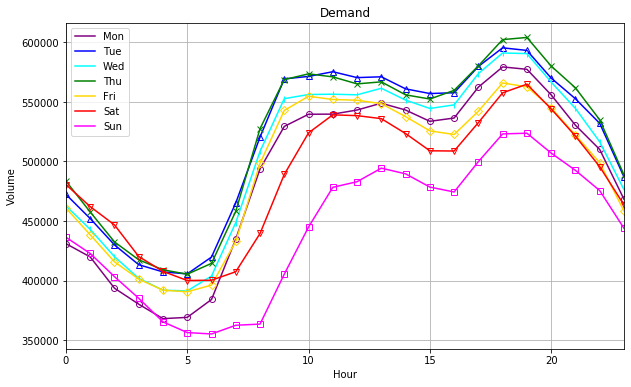

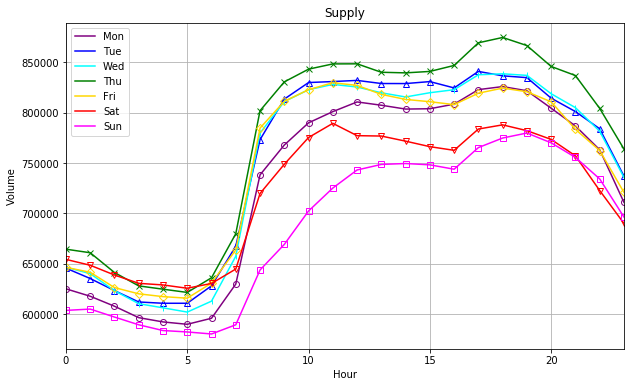

In [31]:
%matplotlib inline
markers = ["o", "^", "|", "x", "D", "v", "s"]
colors = ["purple", "blue", "cyan", "green", "gold", "red", "fuchsia", ]

ax1 = mean_hourly_purchase.plot(color=colors, figsize=(10, 6), linewidth=1.5, grid=True, fillstyle="none")
for i, line in enumerate(ax1.get_lines()):
    line.set_marker(markers[i])
ax1.set_title("Demand")
ax1.set_xlabel("Hour")
ax1.set_ylabel("Volume")

ax2 = mean_hourly_sell.plot(color=colors, figsize=(10, 6), linewidth=1.5, grid=True, fillstyle="none")
for i, line in enumerate(ax2.get_lines()):
    line.set_marker(markers[i])
ax2.set_title("Supply")
ax2.set_xlabel("Hour")
ax2.set_ylabel("Volume")

plt.show()

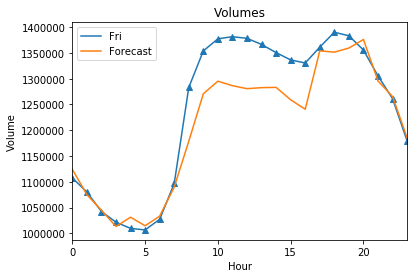

In [241]:
ax2 = (mean_hourly_purchase.values + mean_hourly_sell)[["Fri"]].plot(marker='^')
ax2.set_title("Volumes")
ax2.set_xlabel("Hour")
ax2.set_ylabel("Volume")
pd.DataFrame(forecast, columns=["Forecast"]).plot(ax=ax2)
plt.show()

X.shape = (n_samples, n_features)

y.shape = (n_samples,)

Target. Will be cast to X’s dtype if necessary

In [36]:
ba_purchase_reduced_dst = tools.clean_reduced_bid_data(ba_purchase_reduced_dst)
ba_sell_reduced_dst = tools.clean_reduced_bid_data(ba_sell_reduced_dst)

In [37]:
purchase = ba_purchase_reduced_dst.copy()
sell = ba_sell_reduced_dst.copy()

In [247]:
importlib.reload(tools)

<module 'packages.tools' from 'C:\\Users\\nvolf\\Google Drive 2\\5th Year (Masters) Modules\\Third Semester\\packages\\tools.py'>

In [251]:
# Combine exogenous/explanatory variable classes
price_path = "Datasets/DAMPrices.csv"
prices = tools.preprocess_price_data(price_path).drop("AuctionDateTime", axis=1)
prices = tools.price_dst_adjustment(prices, adt_column=False)

wind_path = "Datasets/WindForecast.csv"
wind_forecast = tools.preprocess_forecast_data(wind_path)
wind_forecast.columns = ["Wind"]

demand_path = "Datasets/DemandForecast.csv"
demand_forecast = tools.preprocess_forecast_data(demand_path)
demand_forecast.columns = ["Demand"]

bm_price_path1 = "Datasets/BMInfo1.csv"
bm_price_path2 = "Datasets/BMInfo2.csv"
bm_price = tools.preprocess_bm_price_data([bm_price_path1, bm_price_path2])

# Preprocessing step to ensure price classes and exogenous classes are consistent,
# e.g. same number of rows, same start/end dates, etc.
#
# Remove exogenous variables from consideration which do not have the same or greater end date than the price classes.
# The idea here is that our main goal is to forecast price class volumes. If the corresponding exogenous variable
# values do not exist, then we can still train the model on the other variables and hence still generate forecasts.
#
# If exog. variables are not removed, then make sure their end dates are the same as the end date of the price classes
# and that the start dates are also the same, where the start date depends on when data becomes fully available for
# all the classes starting from that date.
exog_classes = [prices, bm_price]
planned_classes = [wind_forecast, demand_forecast]
classes_start_dates = list(map(lambda _class: _class.index[0], exog_classes+planned_classes+[purchase, sell]))
latest_start_date = max(classes_start_dates)

for i, exog_class in enumerate(exog_classes):
    if exog_class.index[-1] < purchase.index[-1]:
        exog_classes.remove(exog_class)
    else:
        exog_classes[i] = exog_class.loc[latest_start_date:purchase.index[-1]]

for i, planned_class in enumerate(planned_classes):
    if planned_class.index[-1] < purchase.index[-1]:
        planned_classes.remove(planned_class)
    else:
        planned_classes[i] = planned_class.loc[latest_start_date:purchase.index[-1]]

# Combine exog_classes and planned_classes into DataFrames
exog_classes = reduce(lambda df1, df2: df1.join(df2), exog_classes)
planned_classes = reduce(lambda df1, df2: df1.join(df2), planned_classes)

# Set aside last day of data for testing and use the rest for training
last_day_of_data = dt.datetime.combine(purchase.index.date[-1], dt.datetime.min.time())
test_data_index = pd.date_range(start=last_day_of_data, end=last_day_of_data+dt.timedelta(hours=23), freq='h')

# Test data
test_purchase = purchase.loc[test_data_index]
test_sell = sell.loc[test_data_index]

# Training datav + predictors for forecast
train_purchase = purchase.loc[:last_day_of_data-dt.timedelta(hours=1)]
train_sell = sell.loc[:last_day_of_data-dt.timedelta(hours=1)]
train_exog_classes = exog_classes.loc[:last_day_of_data-dt.timedelta(hours=1)]#[exog_class[:last_day_of_data-dt.timedelta(hours=1)] for exog_class in exog_classes]
train_planned_classes = planned_classes.loc[:test_data_index[-1]]#[planned_class[:last_day_of_data-dt.timedelta(hours=1)] for planned_class in planned_classes]

# Note, since we are only modelling the price classes, we do not need 'test' data for the exog and planned classes.
# We will also make use of the fact that planned variables are known in advance.

In [252]:
print("Train data shape:")
print(train_purchase.shape, train_sell.shape, train_exog_classes.shape, train_planned_classes.shape, '\n')

print("Train data start date:")
print(train_purchase.index[0])
print(train_sell.index[0])
print(exog_classes.index[0])
print(planned_classes.index[0])
    
print('\n')

print("Train data end date:")
print(train_purchase.index[-1])
print(train_sell.index[-1])
print(train_exog_classes.index[-1])
print(train_planned_classes.index[-1])

print('\n')

print("Test data shape:")
print(test_purchase.shape, test_sell.shape, '\n')

print("Test data start date:")
print(test_purchase.index[0])
print(test_sell.index[0])

print('\n')

print("Test data end date")
print(test_purchase.index[-1])
print(test_sell.index[-1])

Train data shape:
(13344, 16) (13344, 23) (13344, 2) (13368, 2) 

Train data start date:
2018-11-13 00:00:00
2018-11-13 00:00:00
2018-11-13 00:00:00
2018-11-13 00:00:00


Train data end date:
2020-05-21 23:00:00
2020-05-21 23:00:00
2020-05-21 23:00:00
2020-05-22 23:00:00


Test data shape:
(24, 16) (24, 23) 

Test data start date:
2020-05-22 00:00:00
2020-05-22 00:00:00


Test data end date
2020-05-22 23:00:00
2020-05-22 23:00:00


15 hours

In [152]:
dt.datetime.today().weekday()

5

In [154]:
days_of_the_week = {"Monday":0, "Tuesday":1, "Wednesday": 2, "Thursday": 3, "Friday": 4, "Saturday": 5, "Sunday": 6}
for day in days_of_the_week:
    

Monday
Tuesday
Wednesday
Thursday
Friday
Saturday
Sunday


In [155]:
start = time.time()


# Function to determine the number of lagged versions of a given predictor to set as dependencies of the target variable
def get_lags(lag_structure, target_class, target_hour, predictor_class, predictor_hour):
    same_class = target_class == predictor_class
    same_hour = target_hour == predictor_hour
    
    if same_class and same_hour:
        return(lag_structure["same_hc"])
    elif same_class and not same_hour:
        return(lag_structure["same_c"])
    elif not same_class and same_hour:
        return(lag_structure["same_h"])
    else:
        return(lag_structure["other"])

# Desired lag structure (user-specified). We are following the same lag structure specified in the paper.
lag_structure = {
    "same_hc": list(range(1,37)),
    "same_h": list(range(1,9)),
    "same_c": list(range(1,9)),
    "other": [1]
}
    
alphas = np.array([i*10**(-3) for i in range(1,10)] + [0.1+i*10**(-2) for i in range(10)]
                 + [0.2+i*10**(-2) for i in range(0,7)] + [0.26+i*10**(-2) for i in range(2,16,2)])


def XModel(reduced_purchase, reduced_sell, exog_classes, planned_classes, lag_structure, model_kwargs={}, verbose=False):
    purchase = reduced_purchase.copy()
    sell = reduced_sell.copy()
    
    # Rename purchase and sell price classes for distinguishing between the two
    purchase.columns = pd.Index([str(column)+"P" for column in reduced_purchase.columns])
    sell.columns = pd.Index([str(column)+"S" for column in reduced_sell.columns])

    # Combine purchase/sell classes into one
    price_classes = purchase.join(sell, how="outer")
    
    # Prepare dataframe to store forecasts
    forecast_start_date = price_classes.index[-1].date()+dt.timedelta(days=1)
    forecast_end_date = dt.datetime.combine(forecast_start_date,dt.datetime.min.time())+dt.timedelta(hours=23)
    forecast_times = pd.date_range(start=forecast_start_date, end=forecast_end_date,freq="H")
    forecasts_df = pd.DataFrame(columns=price_classes.columns, index=forecast_times)
    
    if verbose: print("Building _variables_df dataframes")
#     build_start = time.time()
    
    # Pre-load variables and store in a dataframe (with suffix _variables_df). This is to optimise the
    # training/forecasting step to avoid recalculating the same variable thousands of times.
    train_variables_df = pd.DataFrame(index=pd.unique(price_classes.index.date))
    forecast_variables_df = pd.DataFrame(index=[price_classes.index.date[-1] + dt.timedelta(days=1)])
    
    for hour in range(24):
        if verbose: print("Building hour", hour)
        for price_class in price_classes.columns:
            max_lags = list(range(1,max([len(lags) for lags in lag_structure.values()]) + 1))
            for lag in max_lags:
                variable = price_classes.loc[price_classes.index.hour==hour, price_class]
                variable_name = f"{price_class}_H{hour}-{lag}"
                
                train_variable = variable.shift(lag)
                train_variable.index = train_variable.index.date
                train_variables_df.insert(train_variables_df.shape[1], variable_name, train_variable)
                
                forecast_variable = variable[-lag]
                forecast_variables_df.insert(forecast_variables_df.shape[1], variable_name, forecast_variable)

        for exog_class in exog_classes.columns:
            max_lags = lag_structure["same_h"]
            for lag in max_lags:
                variable = exog_classes.loc[exog_classes.index.hour==hour, exog_class]
                variable_name = f"{exog_class}_H{hour}-{lag}"
                
                train_variable = variable.shift(lag)
                train_variable.index = train_variable.index.date
                train_variables_df.insert(train_variables_df.shape[1], variable_name, train_variable)
                
                forecast_variable = variable[-lag]
                forecast_variables_df.insert(forecast_variables_df.shape[1], variable_name, forecast_variable)

        for planned_class in planned_classes.columns:
            max_lags = list(map(lambda lag: lag-1, lag_structure["same_h"]))
            for lag in max_lags:
                variable = planned_classes.loc[planned_classes.index.hour==hour, planned_class]
                variable_name = f"{planned_class}_H{hour}-{lag}"
                
                train_variable = variable.shift(lag)
                train_variable.index = train_variable.index.date
                train_variables_df.insert(train_variables_df.shape[1], variable_name, train_variable)
                
                forecast_variable = variable[-lag-1]
                forecast_variables_df.insert(forecast_variables_df.shape[1], variable_name, forecast_variable)
    
#     build_end = time.time()
#     print(f"_variables_df build execution time: {build_end-build_start} seconds.")
    
    train_variables_df = train_build
    forecast_variables_df = forecast_build


    fit_start = time.time()
    # Train and forecast values for each given price class at each given hour.
    for target_hour in range(24):
        for target_class in price_classes.columns:
            if verbose: print(f"Now on price class {target_class} at hour {target_hour}.")

            # Fetch the time series corresponding to the price target_class at the target_hour
            target = price_classes.loc[price_classes.index.hour==target_hour, target_class]
            target.index = target.index.date

            # These dataframes will store all the 'predictors' of the target class, consisting of lagged values of other price
            # classes and of the exogenous classes (wind forecast, total volume, electricity price, etc.).
            #
            # train_predictors: predictor values used for training
            # forecast_predictors: predictor values used for forecasting day-ahead prices
            #
            predictors_columns = []
            
            # Build the predictor dataframes (from price classes)
            for price_class in price_classes.columns:
                for predictor_hour in range(24):
                    # Get the specific dependency of the target price class on the current price_class at the current hour
                    lags = get_lags(lag_structure, target_class, target_hour, price_class, predictor_hour)
                    
                    # For each given lag, populate train_predictors and forecast_predictors with the appropriate columns/values
                    for lag in lags:
                        predictors_columns.append(f"{price_class}_H{predictor_hour}-{lag}")

            # (Continued) Build the predictor dataframes (from exogenous, non-planned classes)
            for exog_class in exog_classes.columns:
                for predictor_hour in range(24):
                    # Get the specific dependency of the target price class on the current price_class at the current hour
                    lags = get_lags(lag_structure, target_class, target_hour, exog_class, predictor_hour)

                    # For each given lag, populate train_predictors and forecast_predictors with the appropriate columns/values
                    for lag in lags:
                        predictors_columns.append(f"{exog_class}_H{predictor_hour}-{lag}")

            # (Continued) Build the predictor dataframes (from exogenous, planned classes)
            for planned_class in planned_classes.columns:
                for predictor_hour in range(24):
                    # Get the specific dependency of the target price class on the current price_class at the current hour
                    lags = get_lags(lag_structure, target_class, target_hour, planned_class, predictor_hour)
                    lags = list(map(lambda lag: lag-1, lags))

                    # For each given lag, populate train_predictors and forecast_predictors with the appropriate columns/values
                    # Note that with planned forecasts, we know the (forecasted) value for the delivery hour that we are 
                    # forecasting, so we let the target variable depend on this, i.e. include the unlagged version as predictor
                    for lag in lags:
                        predictors_columns.append(f"{planned_class}_H{predictor_hour}-{lag}")

            # Match the column arrangement of train_predictors with forecast_predictors.
            # This is an important safety measure to ensure that the training and forecasting processes are consistent with each other.
            train_predictors = train_variables_df[predictors_columns]
            forecast_predictors = forecast_variables_df[predictors_columns]

            # Remove rows (samples) with NAs (that arose due to the lagging process in the loop above)
            # so that none of our samples have NA values.
            notna_train_predictors_loc = train_predictors.notna().all(axis=1)
            train_predictors = train_predictors.loc[notna_train_predictors_loc]
            target = target.loc[notna_train_predictors_loc]

            ## Fit the LASSO model (with optimal lambda found via cross-validation)
            # Generate forecast.
            #
            # Get scaling parameters (mean and variance/standard deviation) of train_predictors and target for the LASSO fitting.
            # This is important for allowing interpretability of the model coefficients and to help the algorithm with convergence.
            # The X-model paper implements this same procedure.
            predictors_scale = prep.StandardScaler().fit(X=train_predictors)
            target_scale = prep.StandardScaler().fit(X=pd.DataFrame(target))

            # Apply scaling
            train_predictors_scaled = predictors_scale.transform(X=train_predictors)
            target_scaled = target_scale.transform(pd.DataFrame(target))

            # Before passing into the predict() function, we make sure to scale forecast_predictors
            # using the same scaling parameters that were applied to training_predictors. We then scale back the forecast
            # using the same scaling parameters that were applied to target (but in reverse order).
            model_fit = linear_model.LassoCV(**model_kwargs).fit(X=train_predictors_scaled, y=target_scaled)
            forecast_predictors_scaled = (forecast_predictors-predictors_scale.mean_) / predictors_scale.scale_
            scaled_forecast = model_fit.predict(forecast_predictors_scaled)
            forecast = (scaled_forecast * target_scale.scale_) + target_scale.mean_

            forecasts_df.loc[forecasts_df.index.hour==target_hour, target_class] = forecast
            
#     fit_end = time.time()
#     print(f"Model fitting took {fit_end - fit_start} seconds")
    return(forecasts_df)


XM_forecast = XModel(train_purchase, train_sell, train_exog_classes, train_planned_classes, lag_structure,
                                        model_kwargs=dict(copy_X=False, max_iter=600, n_jobs=-1, alphas=alphas))

end = time.time()
print(f"Overall execution Time: {end - start} seconds")

Building _variables_df dataframes
Now on price class 3000.0P at hour 0.
Now on price class 203.99P at hour 0.
Now on price class 95.2P at hour 0.
Now on price class 56.11P at hour 0.
Now on price class 41.07P at hour 0.
Now on price class 31.0P at hour 0.
Now on price class 23.4P at hour 0.
Now on price class 16.01P at hour 0.
Now on price class 9.1P at hour 0.
Now on price class 0.8P at hour 0.
Now on price class -8.49P at hour 0.
Now on price class -21.62P at hour 0.
Now on price class -41.49P at hour 0.
Now on price class -70.0P at hour 0.
Now on price class -400.92P at hour 0.
Now on price class -500.0P at hour 0.
Now on price class -500.0S at hour 0.
Now on price class -6.01S at hour 0.
Now on price class 15.59S at hour 0.
Now on price class 29.39S at hour 0.
Now on price class 38.0S at hour 0.
Now on price class 45.0S at hour 0.
Now on price class 51.31S at hour 0.
Now on price class 58.17S at hour 0.
Now on price class 65.0S at hour 0.
Now on price class 71.6S at hour 0.
Now on 

Now on price class 71.6S at hour 5.
Now on price class 79.29S at hour 5.
Now on price class 87.7S at hour 5.
Now on price class 97.07S at hour 5.
Now on price class 108.29S at hour 5.
Now on price class 122.48S at hour 5.
Now on price class 142.12S at hour 5.
Now on price class 170.99S at hour 5.
Now on price class 234.11S at hour 5.
Now on price class 380.24S at hour 5.
Now on price class 452.99S at hour 5.
Now on price class 498.9S at hour 5.
Now on price class 2781.38S at hour 5.
Now on price class 3000.0S at hour 5.
Now on price class 3000.0P at hour 6.
Now on price class 203.99P at hour 6.
Now on price class 95.2P at hour 6.
Now on price class 56.11P at hour 6.
Now on price class 41.07P at hour 6.
Now on price class 31.0P at hour 6.
Now on price class 23.4P at hour 6.
Now on price class 16.01P at hour 6.
Now on price class 9.1P at hour 6.
Now on price class 0.8P at hour 6.
Now on price class -8.49P at hour 6.
Now on price class -21.62P at hour 6.
Now on price class -41.49P at hour

Now on price class -21.62P at hour 11.
Now on price class -41.49P at hour 11.
Now on price class -70.0P at hour 11.
Now on price class -400.92P at hour 11.
Now on price class -500.0P at hour 11.
Now on price class -500.0S at hour 11.
Now on price class -6.01S at hour 11.
Now on price class 15.59S at hour 11.
Now on price class 29.39S at hour 11.
Now on price class 38.0S at hour 11.
Now on price class 45.0S at hour 11.
Now on price class 51.31S at hour 11.
Now on price class 58.17S at hour 11.
Now on price class 65.0S at hour 11.
Now on price class 71.6S at hour 11.
Now on price class 79.29S at hour 11.
Now on price class 87.7S at hour 11.
Now on price class 97.07S at hour 11.
Now on price class 108.29S at hour 11.
Now on price class 122.48S at hour 11.
Now on price class 142.12S at hour 11.
Now on price class 170.99S at hour 11.
Now on price class 234.11S at hour 11.
Now on price class 380.24S at hour 11.
Now on price class 452.99S at hour 11.
Now on price class 498.9S at hour 11.
Now 

Now on price class 142.12S at hour 16.
Now on price class 170.99S at hour 16.
Now on price class 234.11S at hour 16.
Now on price class 380.24S at hour 16.
Now on price class 452.99S at hour 16.
Now on price class 498.9S at hour 16.
Now on price class 2781.38S at hour 16.
Now on price class 3000.0S at hour 16.
Now on price class 3000.0P at hour 17.
Now on price class 203.99P at hour 17.
Now on price class 95.2P at hour 17.
Now on price class 56.11P at hour 17.
Now on price class 41.07P at hour 17.
Now on price class 31.0P at hour 17.
Now on price class 23.4P at hour 17.
Now on price class 16.01P at hour 17.
Now on price class 9.1P at hour 17.
Now on price class 0.8P at hour 17.
Now on price class -8.49P at hour 17.
Now on price class -21.62P at hour 17.
Now on price class -41.49P at hour 17.
Now on price class -70.0P at hour 17.
Now on price class -400.92P at hour 17.
Now on price class -500.0P at hour 17.
Now on price class -500.0S at hour 17.
Now on price class -6.01S at hour 17.
Now

Now on price class -41.49P at hour 22.
Now on price class -70.0P at hour 22.
Now on price class -400.92P at hour 22.
Now on price class -500.0P at hour 22.
Now on price class -500.0S at hour 22.
Now on price class -6.01S at hour 22.
Now on price class 15.59S at hour 22.
Now on price class 29.39S at hour 22.
Now on price class 38.0S at hour 22.
Now on price class 45.0S at hour 22.
Now on price class 51.31S at hour 22.
Now on price class 58.17S at hour 22.
Now on price class 65.0S at hour 22.
Now on price class 71.6S at hour 22.
Now on price class 79.29S at hour 22.
Now on price class 87.7S at hour 22.
Now on price class 97.07S at hour 22.
Now on price class 108.29S at hour 22.
Now on price class 122.48S at hour 22.
Now on price class 142.12S at hour 22.
Now on price class 170.99S at hour 22.
Now on price class 234.11S at hour 22.
Now on price class 380.24S at hour 22.
Now on price class 452.99S at hour 22.
Now on price class 498.9S at hour 22.
Now on price class 2781.38S at hour 22.
Now

Now on price class 380.24S at hour 3.
Now on price class 452.99S at hour 3.
Now on price class 498.9S at hour 3.
Now on price class 2781.38S at hour 3.
Now on price class 3000.0S at hour 3.
Now on price class 3000.0P at hour 4.
Now on price class 203.99P at hour 4.
Now on price class 95.2P at hour 4.
Now on price class 56.11P at hour 4.
Now on price class 41.07P at hour 4.
Now on price class 31.0P at hour 4.
Now on price class 23.4P at hour 4.
Now on price class 16.01P at hour 4.
Now on price class 9.1P at hour 4.
Now on price class 0.8P at hour 4.
Now on price class -8.49P at hour 4.
Now on price class -21.62P at hour 4.
Now on price class -41.49P at hour 4.
Now on price class -70.0P at hour 4.
Now on price class -400.92P at hour 4.
Now on price class -500.0P at hour 4.
Now on price class -500.0S at hour 4.
Now on price class -6.01S at hour 4.
Now on price class 15.59S at hour 4.
Now on price class 29.39S at hour 4.
Now on price class 38.0S at hour 4.
Now on price class 45.0S at hour 

Now on price class 45.0S at hour 9.
Now on price class 51.31S at hour 9.
Now on price class 58.17S at hour 9.
Now on price class 65.0S at hour 9.
Now on price class 71.6S at hour 9.
Now on price class 79.29S at hour 9.
Now on price class 87.7S at hour 9.
Now on price class 97.07S at hour 9.
Now on price class 108.29S at hour 9.
Now on price class 122.48S at hour 9.
Now on price class 142.12S at hour 9.
Now on price class 170.99S at hour 9.
Now on price class 234.11S at hour 9.
Now on price class 380.24S at hour 9.
Now on price class 452.99S at hour 9.
Now on price class 498.9S at hour 9.
Now on price class 2781.38S at hour 9.
Now on price class 3000.0S at hour 9.
Now on price class 3000.0P at hour 10.
Now on price class 203.99P at hour 10.
Now on price class 95.2P at hour 10.
Now on price class 56.11P at hour 10.
Now on price class 41.07P at hour 10.
Now on price class 31.0P at hour 10.
Now on price class 23.4P at hour 10.
Now on price class 16.01P at hour 10.
Now on price class 9.1P a

Now on price class 56.11P at hour 15.
Now on price class 41.07P at hour 15.
Now on price class 31.0P at hour 15.
Now on price class 23.4P at hour 15.
Now on price class 16.01P at hour 15.
Now on price class 9.1P at hour 15.
Now on price class 0.8P at hour 15.
Now on price class -8.49P at hour 15.
Now on price class -21.62P at hour 15.
Now on price class -41.49P at hour 15.
Now on price class -70.0P at hour 15.
Now on price class -400.92P at hour 15.
Now on price class -500.0P at hour 15.
Now on price class -500.0S at hour 15.
Now on price class -6.01S at hour 15.
Now on price class 15.59S at hour 15.
Now on price class 29.39S at hour 15.
Now on price class 38.0S at hour 15.
Now on price class 45.0S at hour 15.
Now on price class 51.31S at hour 15.
Now on price class 58.17S at hour 15.
Now on price class 65.0S at hour 15.
Now on price class 71.6S at hour 15.
Now on price class 79.29S at hour 15.
Now on price class 87.7S at hour 15.
Now on price class 97.07S at hour 15.
Now on price clas

Now on price class 58.17S at hour 20.
Now on price class 65.0S at hour 20.
Now on price class 71.6S at hour 20.
Now on price class 79.29S at hour 20.
Now on price class 87.7S at hour 20.
Now on price class 97.07S at hour 20.
Now on price class 108.29S at hour 20.
Now on price class 122.48S at hour 20.
Now on price class 142.12S at hour 20.
Now on price class 170.99S at hour 20.
Now on price class 234.11S at hour 20.
Now on price class 380.24S at hour 20.
Now on price class 452.99S at hour 20.
Now on price class 498.9S at hour 20.
Now on price class 2781.38S at hour 20.
Now on price class 3000.0S at hour 20.
Now on price class 3000.0P at hour 21.
Now on price class 203.99P at hour 21.
Now on price class 95.2P at hour 21.
Now on price class 56.11P at hour 21.
Now on price class 41.07P at hour 21.
Now on price class 31.0P at hour 21.
Now on price class 23.4P at hour 21.
Now on price class 16.01P at hour 21.
Now on price class 9.1P at hour 21.
Now on price class 0.8P at hour 21.
Now on pri

Now on price class 41.07P at hour 2.
Now on price class 31.0P at hour 2.
Now on price class 23.4P at hour 2.
Now on price class 16.01P at hour 2.
Now on price class 9.1P at hour 2.
Now on price class 0.8P at hour 2.
Now on price class -8.49P at hour 2.
Now on price class -21.62P at hour 2.
Now on price class -41.49P at hour 2.
Now on price class -70.0P at hour 2.
Now on price class -400.92P at hour 2.
Now on price class -500.0P at hour 2.
Now on price class -500.0S at hour 2.
Now on price class -6.01S at hour 2.
Now on price class 15.59S at hour 2.
Now on price class 29.39S at hour 2.
Now on price class 38.0S at hour 2.
Now on price class 45.0S at hour 2.
Now on price class 51.31S at hour 2.
Now on price class 58.17S at hour 2.
Now on price class 65.0S at hour 2.
Now on price class 71.6S at hour 2.
Now on price class 79.29S at hour 2.
Now on price class 87.7S at hour 2.
Now on price class 97.07S at hour 2.
Now on price class 108.29S at hour 2.
Now on price class 122.48S at hour 2.
Now 

Now on price class 122.48S at hour 7.
Now on price class 142.12S at hour 7.
Now on price class 170.99S at hour 7.
Now on price class 234.11S at hour 7.
Now on price class 380.24S at hour 7.
Now on price class 452.99S at hour 7.
Now on price class 498.9S at hour 7.
Now on price class 2781.38S at hour 7.
Now on price class 3000.0S at hour 7.
Now on price class 3000.0P at hour 8.
Now on price class 203.99P at hour 8.
Now on price class 95.2P at hour 8.
Now on price class 56.11P at hour 8.
Now on price class 41.07P at hour 8.
Now on price class 31.0P at hour 8.
Now on price class 23.4P at hour 8.
Now on price class 16.01P at hour 8.
Now on price class 9.1P at hour 8.
Now on price class 0.8P at hour 8.
Now on price class -8.49P at hour 8.
Now on price class -21.62P at hour 8.
Now on price class -41.49P at hour 8.
Now on price class -70.0P at hour 8.
Now on price class -400.92P at hour 8.
Now on price class -500.0P at hour 8.
Now on price class -500.0S at hour 8.
Now on price class -6.01S at

Now on price class -70.0P at hour 13.
Now on price class -400.92P at hour 13.
Now on price class -500.0P at hour 13.
Now on price class -500.0S at hour 13.
Now on price class -6.01S at hour 13.
Now on price class 15.59S at hour 13.
Now on price class 29.39S at hour 13.
Now on price class 38.0S at hour 13.
Now on price class 45.0S at hour 13.
Now on price class 51.31S at hour 13.
Now on price class 58.17S at hour 13.
Now on price class 65.0S at hour 13.
Now on price class 71.6S at hour 13.
Now on price class 79.29S at hour 13.
Now on price class 87.7S at hour 13.
Now on price class 97.07S at hour 13.
Now on price class 108.29S at hour 13.
Now on price class 122.48S at hour 13.
Now on price class 142.12S at hour 13.
Now on price class 170.99S at hour 13.
Now on price class 234.11S at hour 13.
Now on price class 380.24S at hour 13.
Now on price class 452.99S at hour 13.
Now on price class 498.9S at hour 13.
Now on price class 2781.38S at hour 13.
Now on price class 3000.0S at hour 13.
Now

Now on price class 234.11S at hour 18.
Now on price class 380.24S at hour 18.
Now on price class 452.99S at hour 18.
Now on price class 498.9S at hour 18.
Now on price class 2781.38S at hour 18.
Now on price class 3000.0S at hour 18.
Now on price class 3000.0P at hour 19.
Now on price class 203.99P at hour 19.
Now on price class 95.2P at hour 19.
Now on price class 56.11P at hour 19.
Now on price class 41.07P at hour 19.
Now on price class 31.0P at hour 19.
Now on price class 23.4P at hour 19.
Now on price class 16.01P at hour 19.
Now on price class 9.1P at hour 19.
Now on price class 0.8P at hour 19.
Now on price class -8.49P at hour 19.
Now on price class -21.62P at hour 19.
Now on price class -41.49P at hour 19.
Now on price class -70.0P at hour 19.
Now on price class -400.92P at hour 19.
Now on price class -500.0P at hour 19.
Now on price class -500.0S at hour 19.
Now on price class -6.01S at hour 19.
Now on price class 15.59S at hour 19.
Now on price class 29.39S at hour 19.
Now o

In [ ]:
importlib.reload(tools)

In [ ]:
test_sell.head()

### 3. Forecast future bid volumes, reconstruct original price curves, then determine corresponding prices

As indicated in the heading, the steps here are as follows:
1. <b>Use the trained model to forecast future bid volumes:</b> Our model should allow for single-step or multi-step forecasts.
2. <b>Reconstruct original price curves</b>
3. <b> Extract information from reconstructed price curves</b>. This includes, of course, the corresponding electricity price. However, we can also obtain other information from the curves, such as the likelihood of price spikes, reflected in the elasticity (slope) of the price curves.

### Further Points to Improve Upon:
* Optimise the code:
    * The same kinds of data preprocessing is done in several places.
    * Multiple functions are created that do similar things. Might be better to combine these functions into one, e.g. `get_price_curves()` and `to_price_curve()`, although in this case, the outputs are the same but the input and methods are completely different.
* Model Assumptions/Methods:
    * Linear relationship between two price bids, without explicitly including more complmex bids, e.g. block bids.
    * Simple dimension reduction technique (price classes)
    * Daylight saving adjustments: interpolation/averaging
    * Holidays were ignored
    * Restructuring procedure could be improved, i.e. bid reconstruction probabilities, use of Bernoulli r.v., etc.
* Data:
    * As of writing, the dataset we are working with is only ROI data, so excluding NI. We should allow for datasets that contain both kinds of data.
    * We could also further include prices from other markets, since the market coupling process influences the market clearing price (I think).

### Things to ruminate and cogitate during one's free time
* Day of the week effect
* choice of set of day lags
* lasso estimator "is consistent and asymptotic normal for the non-zero parameter components"